In [58]:
import pandas as pd
import numpy as np
import operator

import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import langid
from textblob import TextBlob
import string


import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

import pickle
%matplotlib inline

In [2]:
train = pd.read_csv('./train.csv')

In [3]:
train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [4]:
no_insincere = train[train['target']==1].target.count()
no_sincere = train[train['target']==0].target.count()

print('No. of insincere questions:', no_insincere)
print('No. of sincere questions:', no_sincere)
print('% of insincere questions:', train.target.mean())
print('Null score:', 1- train.target.mean())

No. of insincere questions: 80810
No. of sincere questions: 1225312
% of insincere questions: 0.06187017751787352
Null score: 0.9381298224821265


In [5]:
# Storing basic stats about the data in a dataframe, might provide some insights later.
basic_stats = pd.DataFrame([train.shape[0], no_insincere, no_sincere, train.target.mean(), 1- train.target.mean()], 
                           index=['no_of_questions', 'no_of_insincere', 'no_of_sincere',  '%_insinere', 'null_score'], columns=['basic_stats']).T

basic_stats

,no_of_questions,no_of_insincere,no_of_sincere,%_insinere,null_score
basic_stats,1306122.0,80810.0,1225312.0,0.06187,0.93813


Question Length

In [6]:
train['char_length'] = train.question_text.map(lambda x: len(x))

In [7]:
train.head()

,qid,question_text,target,char_length
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,72
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,81
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,67
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,57
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,77


In [8]:
c_max = train.char_length.max()
c_min = train.char_length.min()
c_mean = train.char_length.mean()
c_std = train.char_length.std()
print('Max question length:', c_max)
print('Min question length:', c_min)
print('Mean question length:', c_mean)
print('STD question length:', c_std)

Max question length: 1017
Min question length: 1
Mean question length: 70.67883551459971
STD question length: 38.78427671665139


In [9]:
# question length could be a indicator of insincerity.
train[train.char_length < 5]

,qid,question_text,target,char_length
78445,0f5a41d6752d5d667895,Is,1,3
299304,3a9ae962f1094242e36f,If,1,3
420816,527aac2ce6f12f789fe5,"""",1,1
792939,9b5f4ae97ad53ac06ba6,Do,1,3
995257,c309469a202434b5f1d2,W,1,1


In [10]:
train[train.char_length > 700]

,qid,question_text,target,char_length
163583,1ffca149bd0a19cd714c,What is [math]\overbrace{\sum_{\vartheta=8}^{\...,1,878
443216,56da6b6875d686b48fde,What is [math]\frac{\int_{1x^5}^{3x^{-5}} \tan...,1,1017
522266,663c7523d48f5ee66a3e,"In ""Star Trek 2013"" why did they :\n\n*Spoiler...",0,752


Text(0.5, 1.0, 'Question Length distribution')

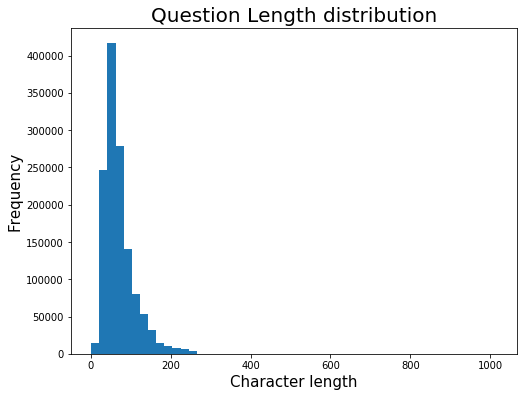

In [11]:
ax = train.char_length.plot.hist(bins=50, figsize=(8,6))
ax.set_xlabel('Character length', fontsize=15)
ax.set_ylabel('Frequency', fontsize=15)
ax.set_title('Question Length distribution', fontsize=20)

In [12]:
train['log_c_length'] = train.char_length.map(lambda x: np.log(x))

Text(0, 0.5, 'Log of Question length')

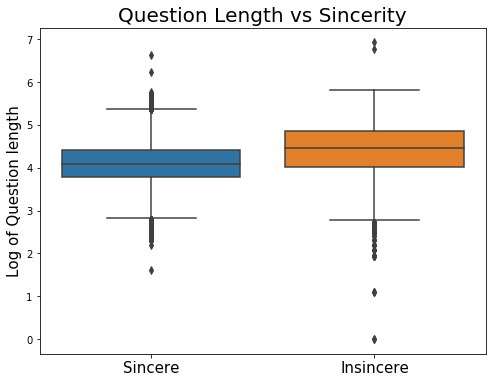

In [13]:
fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(train.target, train.log_c_length)
ax.set_title('Question Length vs Sincerity', fontsize=20)
ax.set_xticklabels(('Sincere', 'Insincere'), fontsize=15)
ax.set_xlabel('', fontsize=15)
ax.set_ylabel('Log of Question length', fontsize=15)

#### Common words

In [62]:
%%time
# all questions as 1 string
full_text = ' '.join(train['question_text'].tolist())

Wall time: 164 ms


In [63]:
len(full_text)

93621303

In [139]:
# Temporarily remove stop words to word EDA, some stopwords might be important for final analysis, and should be lemmatized first
# will for exmaple might have an import meaning.
stopwords = list(nltk.corpus.stopwords.words('english')) + list(string.punctuation) + ["''", '``','’', "'s", "'d", "'ll", "'t"]

In [140]:
%%time
stop_removed_list = [w.lower()  for w in nltk.word_tokenize(full_text) if w.lower() not in stopwords]
stop_removed_text = ' '.join(stop_removed_list)
        

Wall time: 2min 37s


In [141]:
pickle_out = open('stop_removed_text.pickle', 'wb')
pickle.dump(stop_removed_text, pickle_out)
pickle_out.close()

In [142]:
pickle_in = open('stop_removed_text.pickle', 'rb')
stop_removed_text = pickle.load(pickle_in)
pickle_in.close()

In [143]:
freqdist = nltk.FreqDist(stop_removed_text.split(' '))

In [148]:
freqdist.most_common(20)

[('get', 62671),
 ('would', 62397),
 ('best', 62294),
 ('people', 56336),
 ('like', 49094),
 ("n't", 46384),
 ('good', 38267),
 ('one', 34052),
 ('india', 32611),
 ('make', 28196),
 ('think', 26031),
 ('many', 24489),
 ('much', 23436),
 ('time', 23348),
 ('someone', 22766),
 ('life', 22220),
 ('use', 21711),
 ('way', 20783),
 ('know', 20071),
 ('want', 18788)]

In [145]:
%%time
wordcloud = WordCloud(width=800, height=400, background_color='grey').generate(stop_removed_text)

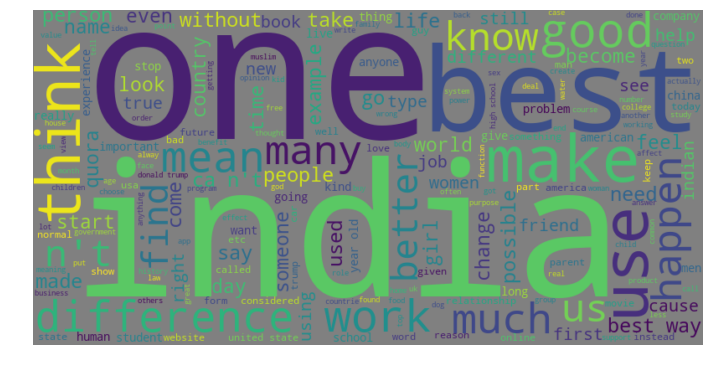

In [146]:
fig, ax = plt.subplots(figsize=(12,16))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [147]:
wordcloud.to_file("wordcloud_all.png")

Sincere questions

In [149]:
%%time
# Combine all sincere questions into 1 string
sincere_text = ' '.join(train[train['target'] == 0]['question_text'].tolist())

Wall time: 249 ms


In [150]:
%%time
# trying different code for speed
sincere_text = ' '.join(train['question_text'][train['target'] == 0].tolist())

Wall time: 196 ms


In [151]:
len(sincere_text)

85615928

In [153]:
# create text without stop words
%%time
stop_removed_sincere = ' '.join([w.lower()  for w in nltk.word_tokenize(sincere_text) if w.lower() not in stopwords])

Wall time: 2min 24s


In [155]:
%%time
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(stop_removed_sincere)

Wall time: 44.5 s


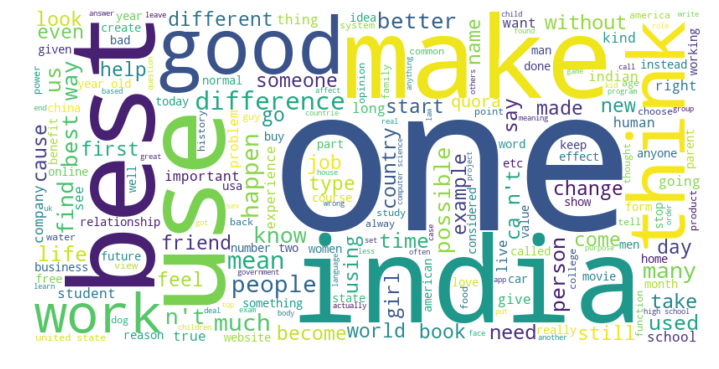

In [156]:
fig, ax = plt.subplots(figsize=(12,16))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [158]:
wordcloud.to_file('wordcloud_sincere.png')

Insincere questions

In [159]:
%%time
# Combine all insincere questions into 1 string.
insincere_text = ' '.join(train['question_text'][train['target'] == 1].tolist())

Wall time: 35.9 ms


In [160]:
%%time
stop_removed_insincere_list = [w.lower()  for w in nltk.word_tokenize(insincere_text) if w.lower() not in stopwords]
stop_removed_insincere = ' '.join(stop_removed_insincere_list)

Wall time: 12.4 s


In [161]:
%%time
wordcloud = WordCloud(width=800, height=400).generate(insincere_text)

Wall time: 5.4 s


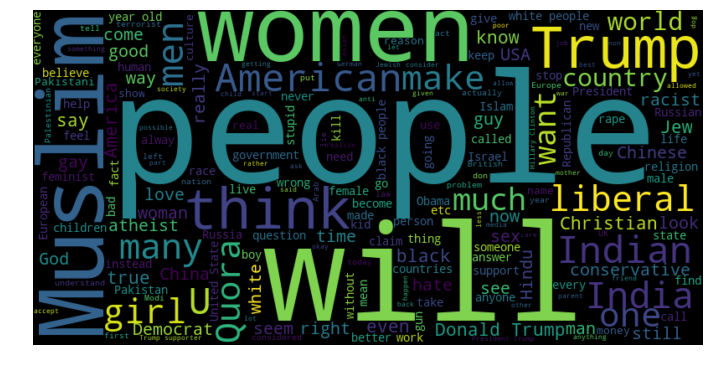

In [162]:
fig, ax = plt.subplots(figsize=(12,16))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [163]:
wordcloud.to_file('wordcloud_insincere.png')

In [164]:
# Words used in insincere questions has the potential to be more controversal, lots of identity terms
# referring to race, nationality, religion, politics, sexual orientation etc.

In [165]:
# Should remove the word 'will' as noise.

#### Common Bigrams

Sincere questions

In [166]:
%%time
# sincere bigram FreqDist
tokens = nltk.word_tokenize(stop_removed_sincere)
bgs_sincere = list(nltk.bigrams(tokens))
bgs_sincere_fd = nltk.FreqDist(bgs_sincere)

Wall time: 37.5 s


In [172]:
bgs_sincere_fd.most_common(20)

[(('best', 'way'), 7006),
 (('ca', "n't"), 6219),
 (('would', 'happen'), 3517),
 (('year', 'old'), 3373),
 (('united', 'states'), 3139),
 (('high', 'school'), 2689),
 (('computer', 'science'), 2631),
 (('look', 'like'), 2596),
 (('feel', 'like'), 2518),
 (('would', 'win'), 2342),
 (('get', 'rid'), 2319),
 (('social', 'media'), 2056),
 (('donald', 'trump'), 2047),
 (('many', 'people'), 2010),
 (('would', 'like'), 1999),
 (('get', 'job'), 1978),
 (('long', 'take'), 1899),
 (('even', 'though'), 1884),
 (('years', 'old'), 1665),
 (("n't", 'want'), 1637)]

In [168]:
bgs_sincere_dict = { '_'.join((k,v)):bgs_sincere_fd[(k,v)] for k,v in bgs_sincere_fd}

In [169]:
%%time
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bgs_sincere_dict)

Wall time: 1.59 s


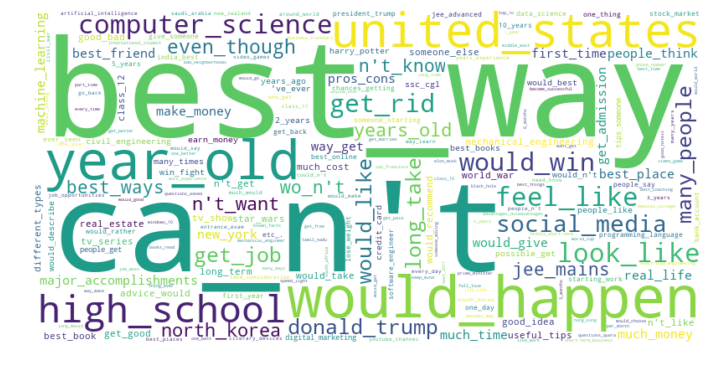

In [170]:
fig, ax = plt.subplots(figsize=(12,16))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [173]:
wordcloud.to_file('wordcloud_sincere_bgms.png')

Insincere questions

In [175]:
# Insincere bigram FreqDist
tokens = nltk.word_tokenize(stop_removed_insincere)
bgs_insincere = list(nltk.bigrams(tokens))
bgs_insincere_fd = nltk.FreqDist(bgs_insincere)
    

In [176]:
bgs_insincere_dict = { '_'.join((k,v)):bgs_insincere_fd[(k,v)] for k,v in bgs_insincere_fd}

In [177]:
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(bgs_insincere_dict)


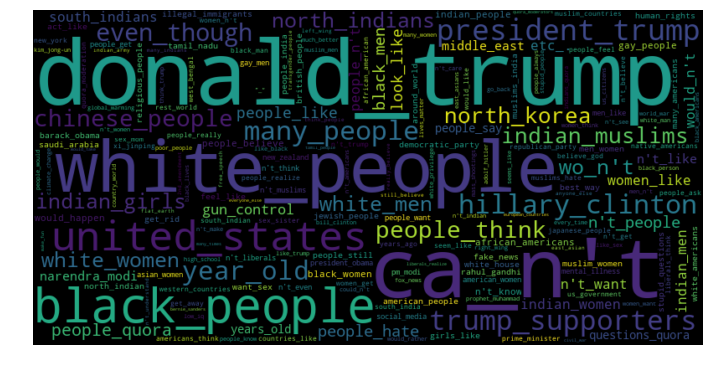

In [178]:
fig, ax = plt.subplots(figsize=(12,16))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [179]:
wordcloud.to_file('wordcloud_insincere_bgms.png')

In [182]:
%%time
# Generate insincere dataframe, reassign index so it's continuous.
insincere_df = pd.DataFrame(train['question_text'][train['target']==1])
insincere_df.reset_index(drop=True, inplace=True)
print(insincere_df.question_text[10])

Would Europeans continue to participate in the Arab war for the destruction of Israel and killing all the Jews, if they knew that god himself defends Israel and he will do to Europeans what the Arabs want to do to the Jews?
Wall time: 15 ms


In [185]:
#Copy over prelim model for presentation

In [189]:
prelim_model_score = pd.DataFrame([93.8, 93.4,93.8,94.8,94.8,94.7,92.4,93.4],
             index=['Null Accuracy','All words, Naive Bayes', 'Non stop words, Naive Bayes', 'Bigram, Naive Bayes','Bigram, DecisioinTree', 'Trigram, Naive Bayes', 'DF2+, Naive Bayes','DF1e3-, Naive Bayes' ])

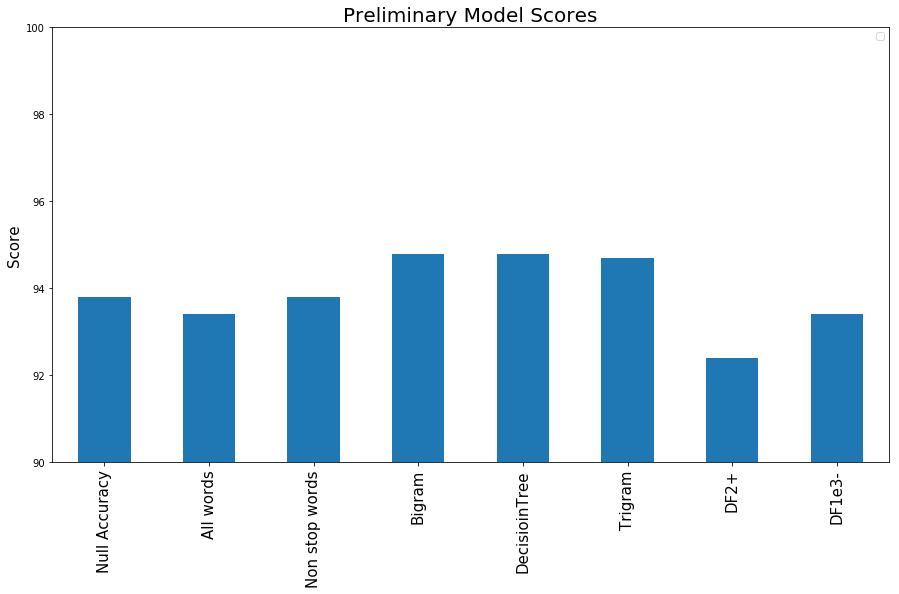

In [222]:

ax = prelim_model_score.plot.bar(figsize=(15,8))
ax.set_ylim(90,100)
ax.set_title('Preliminary Model Scores', fontsize=20)
ax.set_ylabel('Score', fontsize=15)
plt.xticks(rotation=90)
ax.set_xticklabels(['Null Accuracy','All words', 'Non stop words', 'Bigram','DecisioinTree', 'Trigram', 'DF2+','DF1e3-' ],fontsize=15)
ax.legend("") 